# DS100-1 (Applied Data Science)
## Project 3 
### Dominican Republic and Italy  

## Section: A11 
## Group: 5 
## Members:
- ALDAY, Kraemon Joshua
- GARCIA, Enrico Joaquin
- QUITELES, Sean Argie
- REYES, Justin Rupert

## Directions

Create a supervised machine learning (regression) for your COVID-19 data.

The following are the general requirements for the Python code that you will be submitting:

1. Use of the required libraries (Numpy/Pandas, Matplotlib, Scikit-Learn, etc.)

2. Create a regression analysis of your 7-day moving average plots.

3. Create training and test data sets for your machine learning.

4. Evaluate the regression model that you have by displaying any of the following: R2, RMSE, etc.

5. Plot the regression model.



You will be graded based on the following rubrics:

RUBRICS 



Do not forget to indicate the contributions of your group members in the documentation.

Submit a Jupyter Notebook with the following file name format:

DS100-1-[Section]-Group-[Number]-Project-3-Output.ipynb

e.g. DS100-1-A11-Group-1-Project-3-Output.ipynb


## Library Imports

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

## Datasets

In [2]:
cases_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
recovered_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
deaths_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

## Data Cleaning Function 
Since the dataset is cumulative, the daily changes are obtained using `df.diff(axis=1)`

In [3]:
def clean_data(csv_file: str) -> pd.DataFrame:
    """Returns clean data for Italy and the Dominican Republic"""
    df = (pd.read_csv(csv_file)
            .rename({"Country/Region": "Country"}, axis=1) 
            .query('`Country` == "Italy" or `Country` == "Dominican Republic"')
            .set_index('Country')
            .iloc[:,3::] # Excludes the first three rows
            .diff(axis=1) # Get the differences between raws to get the daily changes
                        # Remove this line to get cumulative
            .T) # Transposes the DataFrame to have the dates as index
    df.index = pd.to_datetime(df.index)
    return df

## Applying the Data Cleaning Function to the `csv` files from `github`

In [4]:
Cases = clean_data(cases_csv)
Recovered = clean_data(recovered_csv)
Deaths = clean_data(deaths_csv)

## Merged Table with Active Cases
\begin{equation}Active Cases = Cases - Deaths - Recovered\end{equation}

In [5]:
joint = {'Cases': Cases, 'Recovered': Recovered, 'Deaths': Deaths}
joint = pd.concat(joint, axis=1)

countries = ['Dominican Republic', 'Italy']
for s in ['Dominican Republic', 'Italy']:
    joint[('Active Cases', s)] = joint[('Cases', s)] - joint[('Deaths', s)] - joint[('Recovered', s)]
days = 7
joint_rolling = joint.rolling(days).mean()
joint



Cases                   Recovered          \
Country    Dominican Republic    Italy Dominican Republic   Italy   
2020-01-22                NaN      NaN                NaN     NaN   
2020-01-23                0.0      0.0                0.0     0.0   
2020-01-24                0.0      0.0                0.0     0.0   
2020-01-25                0.0      0.0                0.0     0.0   
2020-01-26                0.0      0.0                0.0     0.0   
...                       ...      ...                ...     ...   
2020-11-01              314.0  29905.0              427.0  2954.0   
2020-11-02              259.0  22253.0              345.0  3637.0   
2020-11-03              257.0  28241.0              348.0  6258.0   
2020-11-04              430.0  30548.0              322.0  5103.0   
2020-11-05              546.0  34502.0              346.0  4961.0   

                       Deaths              Active Cases           
Country    Dominican Republic  Italy Dominican Republic    Italy  
2020-01-22                NaN    NaN                NaN      NaN  
2020-01-23                0.0    0.0                0.0      0.0  
2020-01-24                0.0    0.0                0.0      0.0  
2020-01-25                0.0    0.0                0.0      0.0  
2020-01-26                0.0    0.0                0.0      0.0  
...                       ...    ...                ...      ...  
2020-11-01                4.0  208.0             -117.0  26743.0  
2020-11-02                1.0  233.0              -87.0  18383.0  
2020-11-03                2.0  353.0              -93.0  21630.0  
2020-11-04                5.0  352.0              103.0  25093.0  
2020-11-05                3.0  428.0              197.0  29113.0  

[289 rows x 8 columns]

## Linear and Polynomial Regression Fitting

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import sklearn.metrics as metrics

country = 'Italy'
part = 'Cases'
train = joint_rolling['June 2020':'August 2020'][(part, country)]
X_train = (train.index - train.index[0]).days.values.reshape(-1,1)
test = joint_rolling['September 2020'][(part, country)]
X_test = (test.index - train.index[0]).days.values.reshape(-1,1)

print('\nLinear Regression')
linreg = LinearRegression().fit(X_train, train.values)
lin_train_rmse = metrics.mean_squared_error(train.values, linreg.predict(X_train), squared = False)
lin_test_rmse = metrics.mean_squared_error(test.values, linreg.predict(X_test), squared = False)
print(f'Linear Model Coeff (w): {linreg.coef_:}')
print(f'Linear Model Intercept (b): {linreg.intercept_:.4}')
print(f'R^2 score (training): {linreg.score(X_train, train.values):.4}')
print(f'RMSE score (training): {lin_train_rmse:.4}')
print(f'R^2 score (test): {linreg.score(X_test, test.values):.4}')
print(f'RMSE score (test): {lin_test_rmse:.4}')
X_pred = np.concatenate((X_train,X_test))
Y_pred = linreg.predict(X_pred)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
X_pred_poly = poly.fit_transform(X_pred)

print('\nPolynomial Regression')
polyreg = LinearRegression().fit(X_train_poly, train.values)
poly_train_rmse = metrics.mean_squared_error(train.values, polyreg.predict(X_train_poly), squared = False)
poly_test_rmse = metrics.mean_squared_error(test.values, polyreg.predict(X_test_poly), squared = False)
print(f'Polynomial Model Coeff (w): {polyreg.coef_:}')
print(f'Polynomial Model Intercept (b): {polyreg.intercept_:.4}')
print(f'R^2 score (training): {polyreg.score(X_train_poly, train.values):.4}')
print(f'RMSE score (training): {poly_train_rmse:.4}')
print(f'R^2 score (test): {polyreg.score(X_test_poly, test.values):.4}')
print(f'RMSE score (test): {poly_test_rmse:.4}')
Y_pred_poly = polyreg.predict(X_pred_poly)





Linear Regression
Linear Model Coeff (w): [5.96230798]
Linear Model Intercept (b): 94.96
R^2 score (training): 0.3691
RMSE score (training): 207.0
R^2 score (test): -31.22
RMSE score (test): 753.1

Polynomial Regression
Polynomial Model Coeff (w): [  0.         -20.49266985   0.29071404]
Polynomial Model Intercept (b): 491.8
R^2 score (training): 0.864
RMSE score (training): 96.1
R^2 score (test): -3.449
RMSE score (test): 279.9


## Plotting

<IPython.core.display.Javascript object>


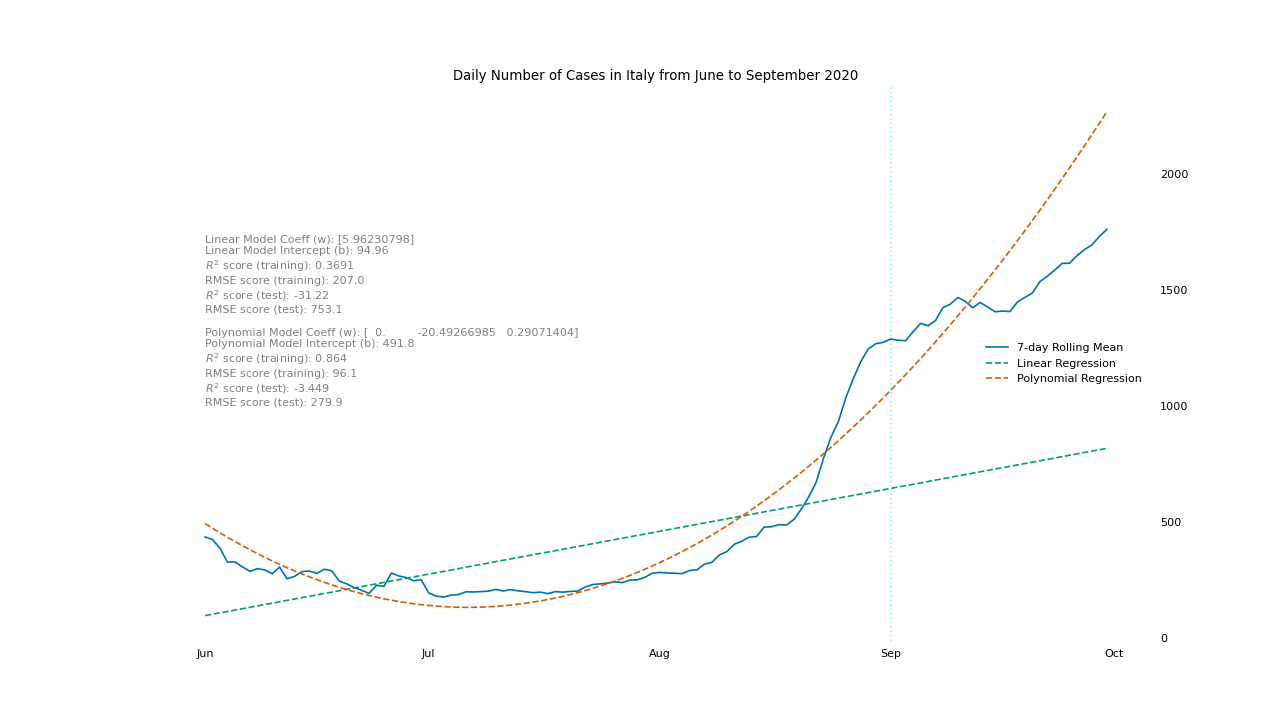

In [7]:
an = '\n'.join((f'Linear Model Coeff (w): {linreg.coef_:}',
                f'Linear Model Intercept (b): {linreg.intercept_:.4}',
                f'$R^2$ score (training): {linreg.score(X_train, train.values):.4}',
                f'RMSE score (training): {lin_train_rmse:.4}',
                f'$R^2$ score (test): {linreg.score(X_test, test.values):.4}',
                f'RMSE score (test): {lin_test_rmse:.4}',
                '',
                f'Polynomial Model Coeff (w): {polyreg.coef_:}',
                f'Polynomial Model Intercept (b): {polyreg.intercept_:.4}',
                f'$R^2$ score (training): {polyreg.score(X_train_poly, train.values):.4}',
                f'RMSE score (training): {poly_train_rmse:.4}',
                f'$R^2$ score (test): {polyreg.score(X_test_poly, test.values):.4}',
                f'RMSE score (test): {poly_test_rmse:.4}'))

plt.style.use('seaborn-colorblind')
plt.figure(figsize=[16,9], dpi=80)
plt.title('Daily Number of Cases in Italy from June to September 2020')
plt.gca().yaxis.tick_right()
plt.gca().tick_params(left=False, bottom = False, right = False)
plt.box() # hide frame

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.axvline(pd.to_datetime('2020-09-01'), linestyle=':', color='cyan', alpha=.5)

plt.plot(joint_rolling['June 2020':'September 2020'].index, 
         joint_rolling['June 2020':'September 2020'][(part, country)], label='7-day Rolling Mean')
plt.plot(joint_rolling['June 2020':'September 2020'].index,Y_pred, '--', label='Linear Regression')
plt.plot(joint_rolling['June 2020':'September 2020'].index,Y_pred_poly, '--', label='Polynomial Regression')

plt.annotate(an, (pd.to_datetime('2020-06-01'), 1000), alpha=.5)
plt.legend(loc='center right', frameon=False)

plt.savefig('Daily Cases with Regression (Italy Jun-Sep 2020).png')
plt.savefig('Daily Cases with Regression (Italy Jun-Sep 2020) 60dpi.png', dpi = 60)
plt.show()

## Sources
COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University<br>
- https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
- https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
- https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv


## Contributions
- ALDAY, Kraemon Joshua – Plotting, Analysis
- GARCIA, Enrico Joaquin – Annotation, Source Code Documentation
- QUITELES, Sean Argie – Linear Regression, Analysis
- REYES, Justin Rupert – Polynomial Regression, Optimization, Source Code Documentation
